In [1]:
from pandas import read_csv, DataFrame,concat,notnull,isnull,Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from scipy.stats import gaussian_kde

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
%matplotlib inline

In [3]:
losses          =read_csv("all_economic_losses.csv")
vo              =read_csv("all_option_values.csv")
losses_wetlands =read_csv("all_losses_wetlands.csv")
vo_and_rp       =read_csv("all_vo_and_rp.csv")

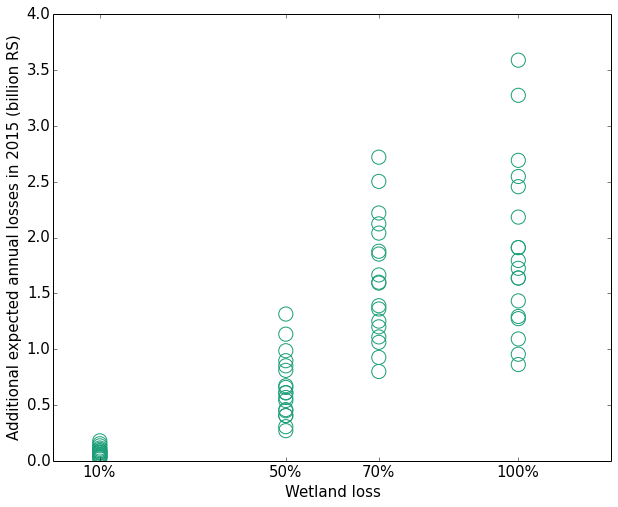

In [81]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select = (losses.GDPgr==0)&(losses.Popgr==0)&(losses.urban_policy==0)&(losses.climate_change==0)
grouped = losses.ix[select,:].groupby("wetland_loss")

for i, (name, group) in enumerate(grouped):
    if i==0:
        continue
    plt.scatter([int(name)]*len(group.annuallosses),group.annuallosses-\
                losses.ix[select&(losses.wetland_loss==0),"annuallosses"].values,\
               marker='o',facecolors='none',edgecolors='#1b9e77',linewidth='1',s=200)
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.set_ylim([0,4])

plt.ylabel('Additional expected annual losses in 2015 (billion RS)')
plt.xlabel('Wetland loss')

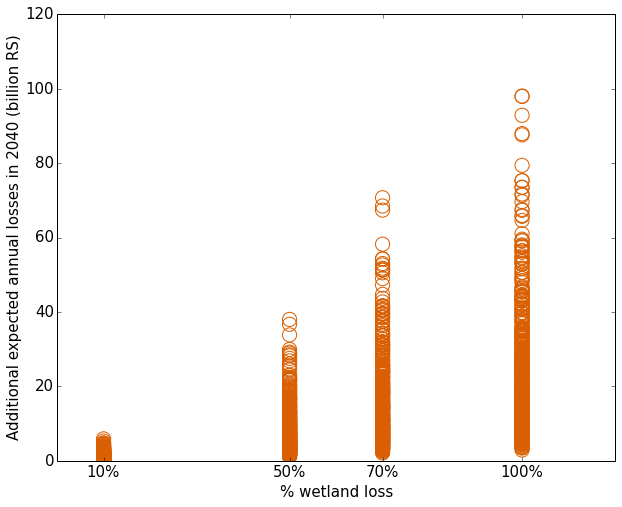

In [86]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,8))

ax=plt.subplot(111)

select2 = (losses.GDPgr>0)&(losses.Popgr>0)&(losses.urban_policy==0)&(losses.climate_change>0)
grouped2 = losses.ix[select2,:].groupby("wetland_loss")
for i, (name, group) in enumerate(grouped2):
    if i==0:
        continue
    plt.scatter([int(name)]*len(group.annuallosses),group.annuallosses\
                -losses.ix[select2&(losses.wetland_loss==0),"annuallosses"].values,\
               marker='o',facecolors='none',edgecolors='#d95f02',linewidth='1',s=200)
    
plt.xticks([10,50,70,100])
aa = ["{}%".format(i) for i in [10,50,70,100]]
ax.set_xticklabels(aa)

ax.set_ylim([0,120])

plt.ylabel('Additional expected annual losses in 2040 (billion RS)')
plt.xlabel('% wetland loss')

In [83]:
aa= group.annuallosses-losses.ix[select2&(losses.wetland_loss==0),"annuallosses"].values

In [85]:
aa.describe()

count    1080.000000
mean       15.716620
std        14.863037
min         0.862395
25%         5.453994
50%        10.495461
75%        20.826067
max        98.055067
dtype: float64

In [4]:
vo_and_rp.ix[vo_and_rp['wetland_loss']==0,:].mean()

wetland_loss    0.000000e+00
option_value    2.093198e+10
risk_premium    1.639660e+09
dtype: float64

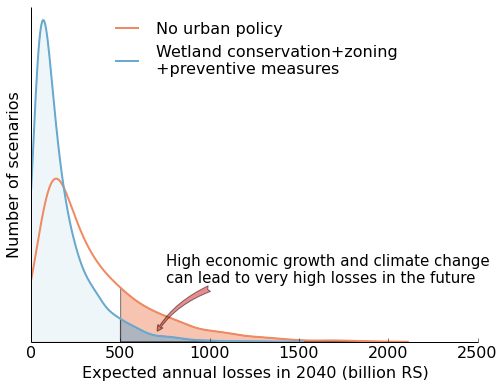

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

select=(losses['urban_policy']==0)&(losses['losses_share']>0.2)&(losses['wetland_loss']>50)

density = gaussian_kde(losses.ix[select,'annuallosses'])
xs = np.linspace(0,max(losses['annuallosses']*1.1),num=300)

high_losses=xs>=500

density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='#ef8a62',label="No urban policy")

ax.fill_between(xs[high_losses], 0, density(xs[high_losses]),facecolor='#ef8a62',alpha=0.5)
plt.annotate('High economic growth and climate change\ncan lead to very high losses in the future', xy=(700, 0.3*density(700)),  xycoords='data',
                    xytext=(10, 50), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#d7191c', ec='black',
                                    alpha=0.5,
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

plt.xlabel('Expected annual losses in 2040 (billion RS)')
plt.ylabel('Number of scenarios')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels([])

xs2 = np.linspace(0,max(losses.ix[~select,'annuallosses']),num=300)

density2 = gaussian_kde(losses.ix[~select,'annuallosses'])
density2.covariance_factor = lambda : .25
density2._compute_covariance()

plt.plot(xs2,density2(xs2),linewidth=2,color='#67a9cf',label="Wetland conservation+zoning\n+preventive measures")
ax.fill_between(xs[high_losses], 0, density2(xs[high_losses]),facecolor='#67a9cf',alpha=0.5)
ax.fill_between(xs[~high_losses], 0, density2(xs[~high_losses]),facecolor='#67a9cf',alpha=0.1)

ax.legend(bbox_to_anchor=[0.35,0.5,0.5,0.5],frameon=False,fontsize=16)

plt.savefig('distrib_annual_losses_urban_policy.png',bbox_inches="tight",dpi=300)

C:\Miniconda3\lib\site-packages\matplotlib\font_manager.py:1236: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


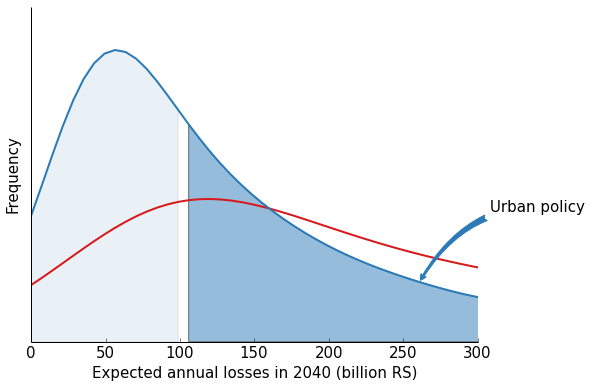

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

select=(losses['urban_policy']==0)&(losses['losses_share']>0.2)

density = gaussian_kde(losses.ix[select,'annuallosses'])
xs = np.linspace(0,max(losses['annuallosses']*1.1),num=300)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='#d7191c')
plt.annotate('No urban policy', xy=(xs[70], density(xs[70])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#d7191c', ec='#d7191c',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

density2 = gaussian_kde(losses.ix[~select,'annuallosses'])
density2.covariance_factor = lambda : .25
density2._compute_covariance()

plt.plot(1,max(density2(xs)),linewidth=2,color='white')

plt.xlabel('Expected annual losses in 2040 (billion RS)')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.set_xlim([0,300])
ax.set_yticklabels([])
plt.savefig('distrib_annual_losses_urban_policy0.png',bbox_inches="tight",dpi=300)



plt.plot(xs,density2(xs),linewidth=2,color='#2c7bb6')

high_losses=xs>=100
ax.fill_between(xs[high_losses], 0, density2(xs[high_losses]),facecolor='#2c7bb6',alpha=0.5)
ax.fill_between(xs[~high_losses], 0, density2(xs[~high_losses]),facecolor='#2c7bb6',alpha=0.1)

plt.annotate('Urban policy', xy=(xs[37], density2(xs[37])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#2c7bb6', ec='#2c7bb6',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

plt.savefig('distrib_annual_losses_urban_policy.png',bbox_inches="tight",dpi=300)

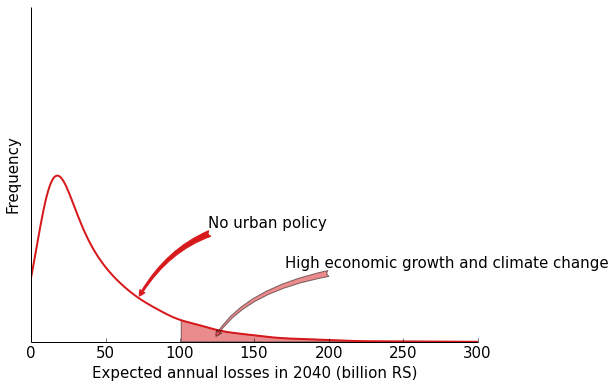

In [16]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

select=(losses['urban_policy']==0)&(losses['losses_share']>0.2)

density = gaussian_kde(losses.ix[select,'annuallosses'])
xs = np.linspace(0,max(losses['annuallosses']*1.1),num=300)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='#d7191c')
plt.annotate('No urban policy', xy=(xs[70], density(xs[70])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#d7191c', ec='#d7191c',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

high_losses=xs>=100
ax.fill_between(xs[high_losses], 0, density(xs[high_losses]),facecolor='#d7191c',alpha=0.5)
plt.annotate('High economic growth and climate change', xy=(xs[120], 0.3*density(xs[120])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='#d7191c', ec='black',
                                    alpha=0.5,
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

density2 = gaussian_kde(losses.ix[~select,'annuallosses'])
density2.covariance_factor = lambda : .25
density2._compute_covariance()

plt.plot(1,max(density2(xs)),linewidth=2,color='white')

plt.xlabel('Expected annual losses in 2040 (billion RS)')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.set_xlim([0,300])
ax.set_yticklabels([])
plt.savefig('distrib_annual_losses_urban_policy1.png',bbox_inches="tight",dpi=300)

C:\Miniconda3\lib\site-packages\matplotlib\font_manager.py:1236: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


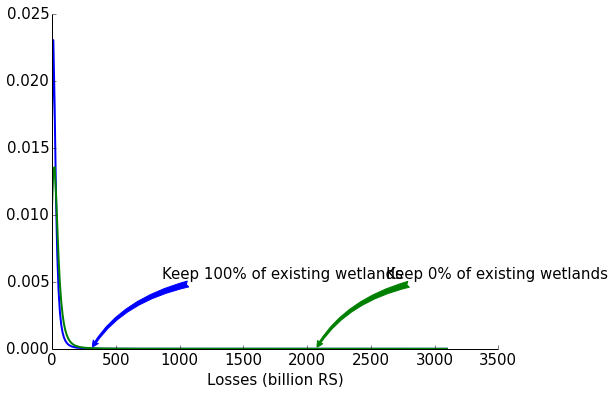

In [7]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

density = gaussian_kde(losses_wetlands['0wetlandloss']/10**9)
xs = np.linspace(0,max(losses_wetlands['100wetlandloss'])/10**9,num=300)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='blue')
plt.annotate('Keep 100% of existing wetlands', xy=(xs[30], density(xs[30])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='blue', ec='blue',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

density = gaussian_kde(losses_wetlands['100wetlandloss']/10**9)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='green')
plt.annotate('Keep 0% of existing wetlands', xy=(xs[200], density(xs[200])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='green', ec='green',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )
plt.xlabel('Losses (billion RS)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#plt.savefig('all_losses_per_wetland_loss.png',bbox_inches="tight",dpi=500)

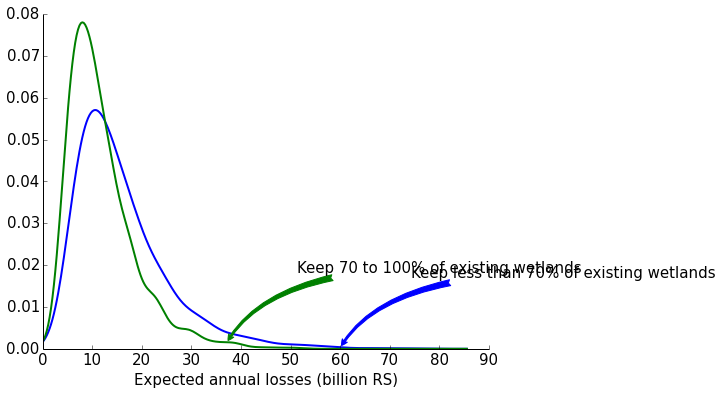

In [36]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

select=losses['wetland_loss']>30

density = gaussian_kde(losses.ix[select,'annuallosses'])
xs = np.linspace(0,max(losses['annuallosses']*1.1),num=300)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='blue')
plt.annotate('Keep less than 70% of existing wetlands', xy=(xs[210], density(xs[210])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='blue', ec='blue',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )
density = gaussian_kde(losses.ix[~select,'annuallosses'])
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='green')
plt.annotate('Keep 70 to 100% of existing wetlands', xy=(xs[130], density(xs[130])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='green', ec='green',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )
plt.xlabel('Expected annual losses (billion RS)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')